In [ ]:
from KoopmanismResponse.dynamical_systems.Models import Arnold_map
from KoopmanismResponse.utils.data_processing import (
    get_spectral_properties,
    get_acf,
    Koopman_correlation_function,
    get_observables_response_ArnoldMap
)
from KoopmanismResponse.utils.paths import get_data_folder_path
from KoopmanismResponse.EDMD.EDMD import Edmd_Fourier
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
two_dim_map = Arnold_map()

In [3]:
two_dim_map.set_random_initial_condition()
t, X = two_dim_map.integrate()

100%|██████████| 100000/100000 [00:01<00:00, 67783.83it/s]


In [7]:
edmd = Edmd_Fourier()
edmd.max_wave_vector = 8
edmd.box_length = 1
edmd._set_indices()

In [8]:
# Perform algorithm and get spectral properties
K = edmd.perform_edmd(data=X)
nus, V, W = get_spectral_properties(K)

100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


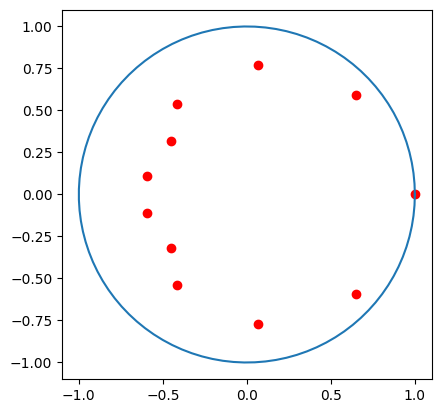

In [9]:
nus_plot = nus[:11]
fig, ax = plt.subplots()
thetas = np.linspace(0,2*np.pi,100)
ax.plot(np.cos(thetas),np.sin(thetas))
ax.scatter(np.real(nus_plot), np.imag(nus_plot),color='r')
ax.set_aspect('equal')

Text(0.5, 0, '$t$')

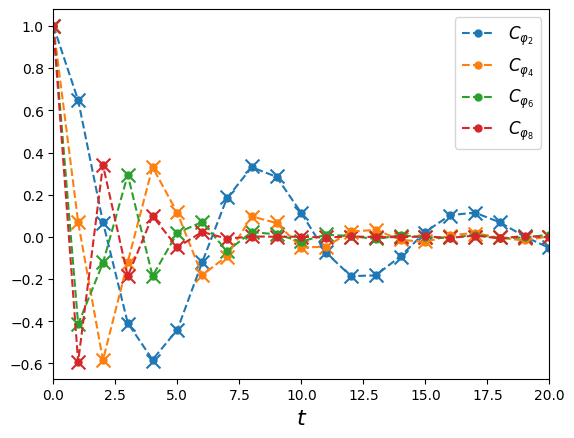

In [10]:
numbers = [1,3,5,7]
nlags = 30
Phi_traj = edmd.evaluate_koopman_eigenfunctions_batch(X,V)
fig , ax = plt.subplots()

for i,number in enumerate(numbers):
    lags, cf = get_acf(Phi_traj[:,number], nlags = nlags,Dt=1)
    cf_th = np.real( nus[number]**lags )
    ax.plot(lags,cf/cf[0],'--o',label= fr"$C_{{ \varphi_{number+1} }}$",markersize=5 )
    ax.scatter(lags,cf_th /cf_th[0],marker= 'x',s=100 )
    ax.set_xlim(0,20)
    
ax.legend(fontsize=12)
ax.set_xlabel("$t$",size=16)   

In [11]:
# Correlation functions from trajectory
x , y = X[:,0] , X[:,1]
observables = [np.sin(2*np.pi*x)*np.sin(2*np.pi*y) , x**2 + y**2 , np.atan(x)*np.log(y + 0.1)]
cf_num = [get_acf(obs,nlags = nlags,Dt=1)[1] for obs in observables]

# Taking the projections w.r.t. Lebesgue of the functions
grid = np.linspace(0,1,200)
dx = grid[1] - grid[0]
dV = dx**2

Xg , Yg = np.meshgrid(grid,grid,indexing='ij')
grid_points = np.stack([Xg.ravel(), Yg.ravel()], axis=1)

observables = [
    np.sin(2 * np.pi * Xg) * np.sin(2 * np.pi * Yg),
    Xg**2 + Yg**2,
    np.atan(Xg) * np.log(Yg + 0.1)
]
observables_vals = [obs.ravel() for obs in observables]



Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
G_Lebesgue = Psi_Lebesgue.conj().T @ Psi_Lebesgue * dV #np.diag(1/(2*np.pi)*np.ones(len(edmd.indices)))

projections =  [np.linalg.pinv(G_Lebesgue) @ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in observables_vals] 

In [12]:
# Evaluate the Koopman projections and the reconstruction
Koop_projections = [W.conj().T @ proj for proj in projections]
M = V.conj().T @ edmd.G @ V 
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M.T, eigenvalues=nus, alpha1=koop_proj, alpha2=koop_proj
    ) for koop_proj in Koop_projections
]

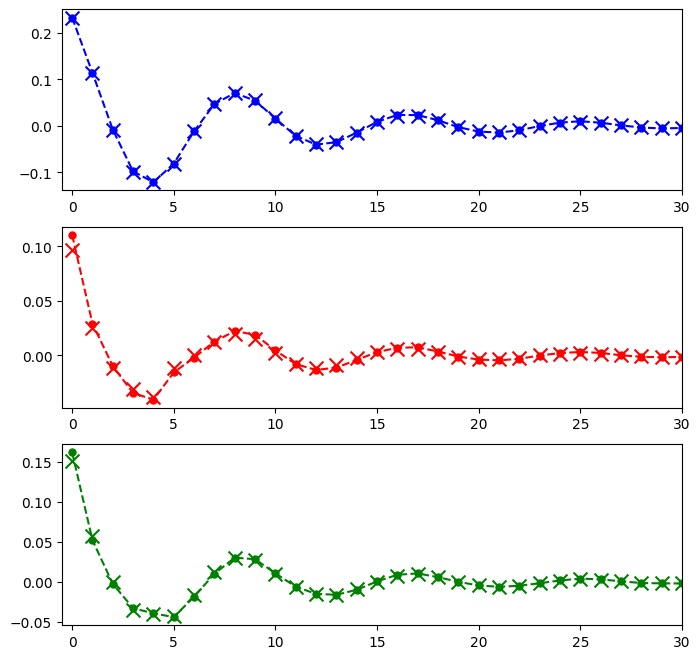

In [13]:
fig, ax = plt.subplots(nrows=3,figsize=(8,8))
labels = [f"$x$", f"$\sin^2(x)$" , f"$\ln(x+\delta)$"]
colors = ['b','r','g']
for index , (cf, Koop_rec,label)  in enumerate( zip( cf_num , Koop_reconstruction, labels) ):
    Koop_cf = np.real( np.asarray( [Koop_rec(lag) for lag in lags] ) )

    ax[index].plot(lags,cf,'--o',markersize=5,label=label,color=colors[index])
    ax[index].scatter(lags,Koop_cf ,s=100,marker="x",c=colors[index])

    ax[index].set_xlim(-0.5,30)
# ax.legend()

### Response

In [ ]:
data_folder_path = get_data_folder_path()
f_name = "response_two_dimensional_map_sinusoidal_perturbation.pkl"

with open(data_folder_path / f_name,"rb") as f:
    response_experiments_results = pickle.load(f)

RP = response_experiments_results["Positive Response"]
RM = response_experiments_results["Negative Response"]
amplitudes = response_experiments_results["Amplitudes"]
response_settings = response_experiments_results["Response Settings"]

t_resp = np.arange(1,response_settings.M+1)
G = np.zeros(RP[0].shape)
individual_responses = []
for rp , rm , amplitude in zip(RP,RM,amplitudes):
    response = (rp - rm) / (2*amplitude) 
    individual_responses.append(response)
    G +=  response
    
G /= len(amplitudes)

fig, ax = plt.subplots()
for x in individual_responses:
    ax.plot(x[:,0])

In [ ]:
# Finding projections of the observables
obs_grid = get_observables_response_ArnoldMap(grid_points/(2*np.pi))
projections =  [np.linalg.pinv(G_Lebesgue) @ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in obs_grid.T] 
# Evaluate the Koopman projections and the reconstruction
Koop_projections = [W.conj().T @ proj for proj in projections]

In [ ]:
Gamma_data = Arnold_map()
Gamma_data.M = 10**6
Gamma_data.set_random_initial_condition()
t, x_Gamma = Gamma_data.integrate()

scaled_Gamma , scale_factor = scale_data(X)
x_Gamma, y_Gamma = scaled_Gamma[:,0] , scaled_Gamma[:,1]

In [ ]:
Psi_traj = edmd.evaluate_dictionary_batch(scaled_Gamma)
Psi_traj * np.sin(2*np.pi (x_Gamma))

In [ ]:
# rho0 , edges = np.histogramdd(X,bins=[200,200],density=True)

# rho_plot = rho0.copy()
# rho_plot[rho_plot < 10**(-4)] = np.nan
# xedges , yedges = edges

# # Coordinates for plotting (bin centers)
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# # Coordinates for plotting (bin centers)
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# # Plot
# plt.figure(figsize=(6, 5))
# plt.pcolormesh(Xc, Yc, rho_plot, cmap='inferno')
# plt.colorbar(label='Invariant density')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.tight_layout()